In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *

### Some comments about replay buffer implementation

In [2]:
class ReplayBuffer: 
    """
    Fixed capacity buffer implemented as circular queue
    Transitions are stored as (s, a, r, s', done) tuples
    """
    def __init__(self, capacity):
        self.samples = np.ndarray(capacity, dtype=object)
        self.capacity = capacity
        self.counter = 0
        self.flag = False
        
    def size(self):
        if self.flag:
            return self.capacity
        else:
            return self.counter
        
    def add(self, sample):
        self.samples[self.counter] = sample
        
        self.counter += 1
        if self.counter >= self.capacity:
            self.counter = 0
            self.flag = True
            
    def sample(self, n):
        n = min(n, self.size())
        
        size = self.size()
        if size < self.capacity:
            return np.random.choice(self.samples[:size], n, replace=False)
        else:
            return np.random.choice(self.samples, n, replace=False)

In [3]:
class Agent:
    def __init__(self, state_dim, action_dim, learning_rate):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.epsilon = 1.0
        
        # Create the neural network
        self.state_var = input(state_dim, np.float32)
        self.action_var = input(action_dim, np.float32)
        
        self.model = Sequential([
            Dense(64, activation=relu),
            Dense(action_dim)
        ])(self.state_var)
        
        loss = reduce_mean(square(self.model - self.action_var), axis=0)
        lr_schedule = learning_rate_schedule(self.learning_rate, UnitType.sample)
        learner = sgd(self.model.parameters, lr_schedule)
        self.trainer = Trainer(self.model, loss, learner)
    
    def predict(self, state):
        """
        Feeds a state through our model to obtain the values of each action
        """
        return self.model.eval(state)
    
    def act(self, state):
        """
        Selects an action using the epoch-greedy approach
        """
        prob = np.random.randn(1)
        if prob > self.epsilon:
            # exploit (greedy)
            return np.argmax(self.predict(state))
        else:
            # explore (random action)
            return np.random.randint(0, self.action_dim)
        
    def update_epsilon(self, episode):
        """
        Updates epsilon using exponential decay with the decay rate chosen such
        that epsilon is 0.05 by episode 8000
        """
        self.epsilon = max(math.exp(-3.74e-4 * episode), 0.05)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step using the provided state and target
        """
        self.trainer.train_minibatch({self.state_var: x, self.action_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the trained model over n episodes
        """
        episode = 0
        rewards = 0
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
            
        return rewards / float(n)

In [4]:
def initialize_buffer(env, buffer):
    """
    Initializes the replay buffer using experiences generated by taking random actions
    """
    actions = env.action_space.n
    s = env.reset()
    
    while buffer.size() < buffer.capacity:
        a = np.random.randint(0, actions)
        s_, r, done, info = env.step(a)
        
        buffer.add((s, a, r, s_, done))
        
        if done:
            s = env.reset()
        else:
            s = s_

In [5]:
def train(env, agent, buffer, episodes, gamma, minibatch_size):
    """
    param env: The gym environment to train with
    param agent: The agent to train
    param buffer: The replay buffer to sample experiences from
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    param minibatch_size: The number of transitions to sample for training
    """
    episode = 0
    rewards = 0
    log_freq = 200
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select an action using policy derived from Q (e-greedy)
        a = agent.act(s)
        
        # Take action and observe the next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)
        
        # Store transition in replay buffer
        buffer.add((s, a, r, s_, done))
        
        s = s_
        rewards += r
        
        # Sample random transitions from replay buffer
        batch = buffer.sample(minibatch_size)
        
        # Compute targets, y_i
        states = np.array([obs[0] for obs in batch], dtype=np.float32)
        states_ = np.array([obs[3] for obs in batch], dtype=np.float32)
        
        y = agent.predict(states)
        q_next = agent.predict(states_)
        
        for i in range(minibatch_size):
            p, a, r, p_, d = batch[i]
            if d:
                y[i, a] = r
            else:
                y[i, a] = r + gamma * np.amax(q_next[i])
        
        # Train using state and computed target
        agent.train(states, y)
        
        if done:
            # Episode over, reset environment
            episode_rewards.append(rewards)
            rewards = 0
            
            episode += 1
            agent.update_epsilon(episode)
            s = env.reset().astype(np.float32)
            
            if episode % log_freq == 0:
                ave = sum(episode_rewards[(episode - log_freq):]) / float(log_freq)
                print('Episode = {}, Average rewards = {}'.format(episode, ave))
                
    return episode_rewards

In [6]:
gamma = 0.60
learning_rate = 0.00025
episodes = 10000
buffer_capacity = 32
minibatch_size = 8

In [7]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape
action_dim = env.action_space.n 

[2017-04-21 16:02:41,655] Making new env: CartPole-v0


In [8]:
buffer = ReplayBuffer(buffer_capacity)
agent = Agent(state_dim, action_dim, learning_rate)

In [9]:
initialize_buffer(env, buffer)
rewards = train(env, agent, buffer, episodes, gamma, minibatch_size)

Episode = 200, Average rewards = 19.32
Episode = 400, Average rewards = 21.325
Episode = 600, Average rewards = 28.395
Episode = 800, Average rewards = 30.76
Episode = 1000, Average rewards = 33.595
Episode = 1200, Average rewards = 34.285
Episode = 1400, Average rewards = 35.105
Episode = 1600, Average rewards = 39.34
Episode = 1800, Average rewards = 39.99
Episode = 2000, Average rewards = 40.285
Episode = 2200, Average rewards = 36.96
Episode = 2400, Average rewards = 46.825
Episode = 2600, Average rewards = 47.305
Episode = 2800, Average rewards = 50.95
Episode = 3000, Average rewards = 51.245
Episode = 3200, Average rewards = 60.1
Episode = 3400, Average rewards = 61.915
Episode = 3600, Average rewards = 60.69
Episode = 3800, Average rewards = 65.125
Episode = 4000, Average rewards = 62.395
Episode = 4200, Average rewards = 63.98
Episode = 4400, Average rewards = 67.3
Episode = 4600, Average rewards = 67.235
Episode = 4800, Average rewards = 70.525
Episode = 5000, Average rewards 

In [14]:
buffer2 = ReplayBuffer(1)
agent2 = Agent(state_dim, action_dim, learning_rate)

In [15]:
rewards2 = train(env, agent2, buffer, episodes, gamma, 1)

Episode = 200, Average rewards = 20.685
Episode = 400, Average rewards = 20.825
Episode = 600, Average rewards = 21.85
Episode = 800, Average rewards = 19.03
Episode = 1000, Average rewards = 19.39
Episode = 1200, Average rewards = 19.575
Episode = 1400, Average rewards = 31.09
Episode = 1600, Average rewards = 34.495
Episode = 1800, Average rewards = 32.2
Episode = 2000, Average rewards = 29.15
Episode = 2200, Average rewards = 34.545
Episode = 2400, Average rewards = 40.54
Episode = 2600, Average rewards = 41.34
Episode = 2800, Average rewards = 43.715
Episode = 3000, Average rewards = 45.525
Episode = 3200, Average rewards = 47.57
Episode = 3400, Average rewards = 47.61
Episode = 3600, Average rewards = 47.385
Episode = 3800, Average rewards = 50.05
Episode = 4000, Average rewards = 50.3
Episode = 4200, Average rewards = 51.7
Episode = 4400, Average rewards = 50.56
Episode = 4600, Average rewards = 56.615
Episode = 4800, Average rewards = 60.75
Episode = 5000, Average rewards = 52.1

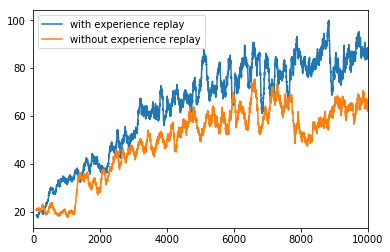

In [16]:
pd.Series(rewards).rolling(window=100).mean().plot(label='with experience replay')
pd.Series(rewards2).rolling(window=100).mean().plot(label='without experience replay')
plt.legend()
plt.show()

In [17]:
eval_episodes = 100
ave_er = agent.evaluate(env, eval_episodes)
ave_no_er = agent2.evaluate(env, eval_episodes)
print('Average reward (without experience replay) = {}'.format(ave_no_er))
print('Average reward (with experience replay) = {}'.format(ave_er))


Average reward (without experience replay) = 134.37
Average reward (with experience replay) = 177.94


In [21]:
s = env.reset()
done = False
while not done:
    env.render()
    a = np.argmax(agent2.predict(s.astype(np.float32)))
    s, r, done, info = env.step(a)

In [ ]:
env.close()